In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

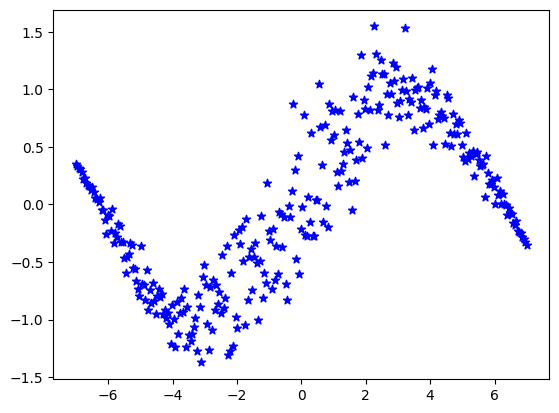

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

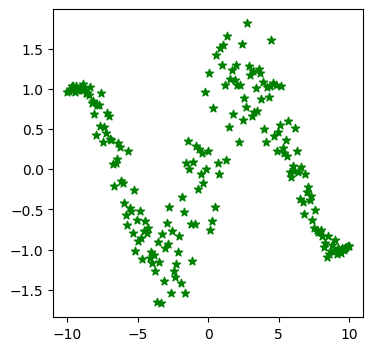

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [6]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
modelSamples = 50

In [8]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        self.hidden_size = 35

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.mu = nn.Linear(self.hidden_size, 1)
        self.var = nn.Linear(self.hidden_size, 1)

    def forward(self, x):

        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        input_noise = torch.normal(0, 1, size=(x.shape[0], self.hidden_size))

        t           = torch.tanh(self.t1(input_noise))
        t           = torch.tanh(self.t2(t))
        prod        = torch.multiply(t,h)

        mu = self.mu(prod)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(prod))
        return mu, var


def make_plot_dpo(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()



In [9]:
net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

DeepONet(
  (b1): Linear(in_features=1, out_features=35, bias=True)
  (b2): Linear(in_features=35, out_features=35, bias=True)
  (t1): Linear(in_features=35, out_features=35, bias=True)
  (t2): Linear(in_features=35, out_features=35, bias=True)
  (mu): Linear(in_features=35, out_features=1, bias=True)
  (var): Linear(in_features=35, out_features=1, bias=True)
)
Params: 3922


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
net.to(device);

In [11]:
def MLE_dopnn():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


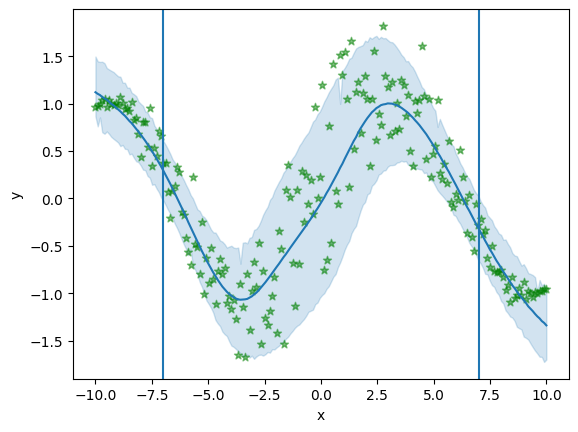

Epoch 149 | batch train loss: -1.3588956594467163 | test loss: 0.17015906022145197
Epoch 149 |batch train mse:0.024554817005991936| test mse:0.14997278096584174


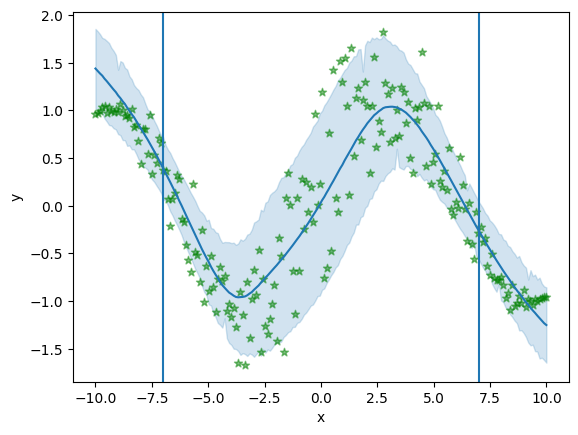

Epoch 149 | batch train loss: -0.6628366112709045 | test loss: 0.40083611470002395
Epoch 149 |batch train mse:0.08819828182458878| test mse:0.15179616556717798


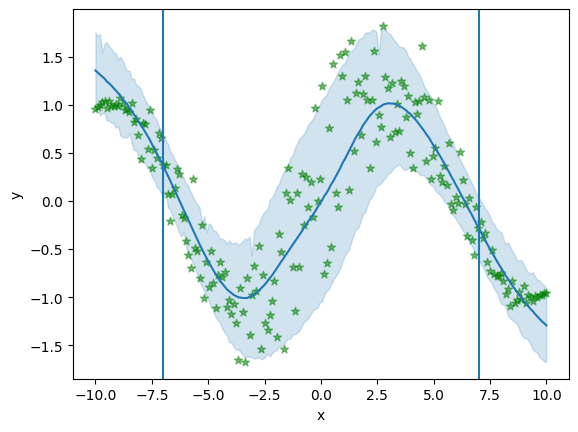

Epoch 149 | batch train loss: -1.037784218788147 | test loss: 0.268096916950666
Epoch 149 |batch train mse:0.07829219102859497| test mse:0.1394867988733145


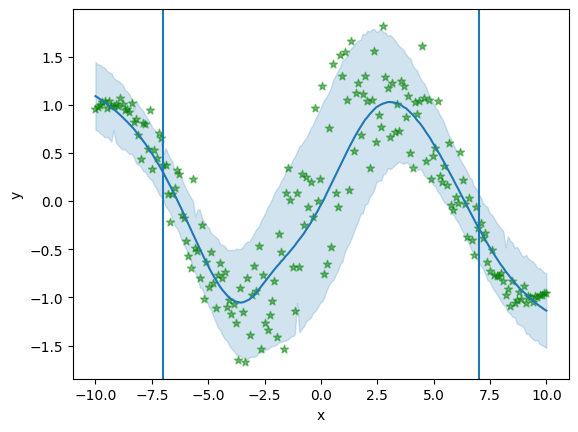

Epoch 149 | batch train loss: -1.3358405828475952 | test loss: 0.008791508009800544
Epoch 149 |batch train mse:0.035863518714904785| test mse:0.13794964064772314


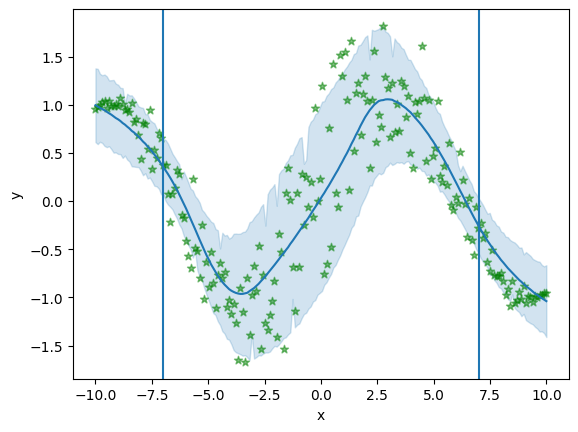

Epoch 149 | batch train loss: -0.6923930048942566 | test loss: 0.039361644249696
Epoch 149 |batch train mse:0.08876070380210876| test mse:0.13721979194535658


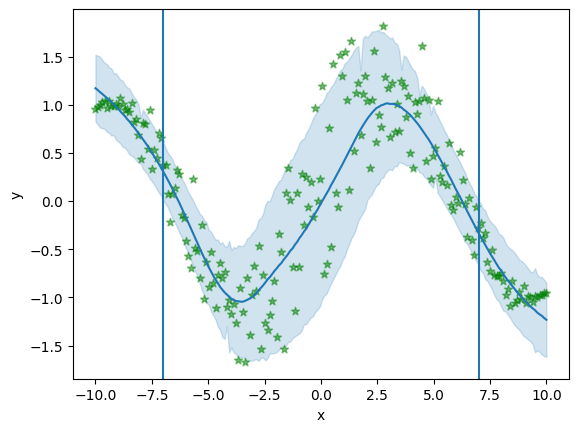

Epoch 149 | batch train loss: -1.3988193273544312 | test loss: 0.2672726626579578
Epoch 149 |batch train mse:0.05849712714552879| test mse:0.14617288743074125


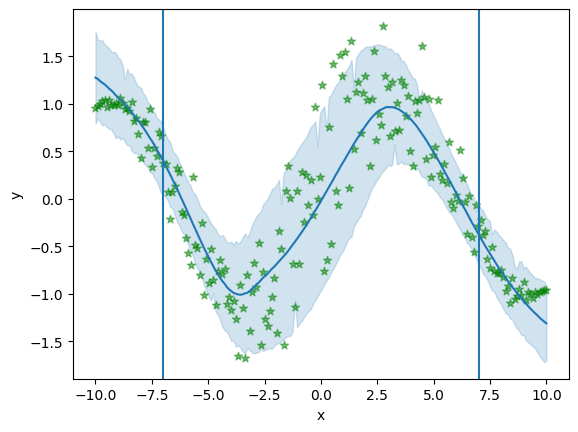

Epoch 149 | batch train loss: -0.7712924480438232 | test loss: 0.06563454407912034
Epoch 149 |batch train mse:0.10412947088479996| test mse:0.14787770721774834


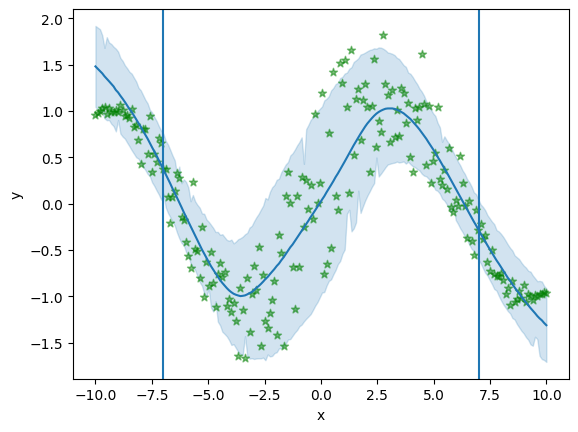

Epoch 149 | batch train loss: -1.2554149627685547 | test loss: 0.7296819984912872
Epoch 149 |batch train mse:0.034081876277923584| test mse:0.15360715584113047


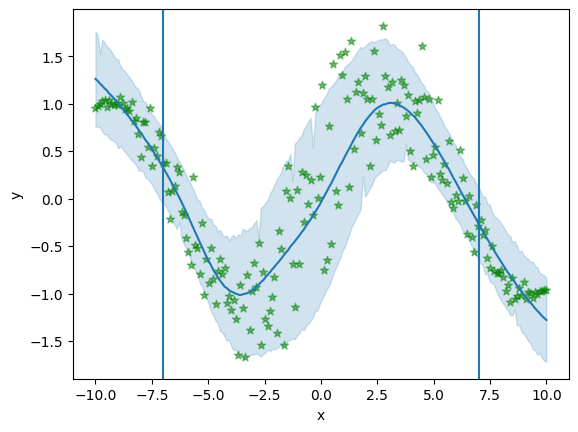

Epoch 149 | batch train loss: -1.3319458961486816 | test loss: 0.13032671809196472
Epoch 149 |batch train mse:0.029432589188218117| test mse:0.14866966983446708


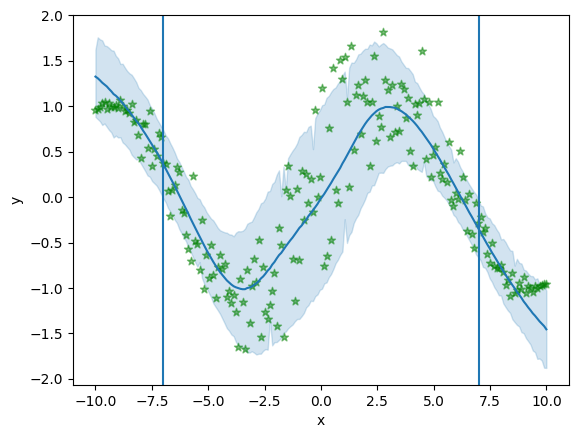

Epoch 149 | batch train loss: -1.4692906141281128 | test loss: 0.21506153964079344
Epoch 149 |batch train mse:0.04263365641236305| test mse:0.1430203691124916


In [12]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

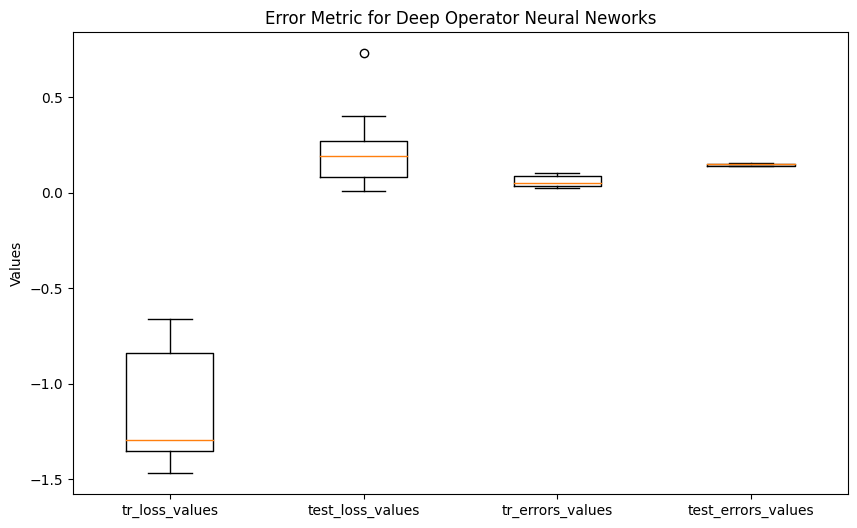

In [13]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metric for Deep Operator Neural Neworks')

# Show the plot
plt.show()


In [14]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.358896      0.170159                     0.024555   
2       -0.662837      0.400836                     0.088198   
3       -1.037784      0.268097                     0.078292   
4       -1.335841      0.008792                     0.035864   
5       -0.692393      0.039362                     0.088761   
6       -1.398819      0.267273                     0.058497   
7       -0.771292      0.065635                     0.104129   
8       -1.255415      0.729682                     0.034082   
9       -1.331946      0.130327                     0.029433   
10      -1.469291      0.215062                     0.042634   

    Mean Squared Testing Error  
1                     0.149973  
2                     0.151796  
3                     0.139487  
4                     0.137950  
5                     0.137220  
6                     0.146173  
7                     0.147878  
8                     0.153607 

In [15]:
df.to_csv('DeepoNet-10-run.csv')

In [16]:
df['Mean Squared Testing Error'].std()

0.005862723137252155